# Zotec Assessment

In [173]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [174]:
# Read csv file into dataframe and print first 5 rows
df = pd.read_csv('NutritionData.csv', encoding_errors='ignore')
df.head()

,NDB_No,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,...,Vit_D_IU,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2
0,1001,"BUTTER,WITH SALT",15.87 g,717,0.85,81.11,2.11,0.06,0.0,0.06,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72 g,718,0.49,78.30,1.62,2.87,0.0,0.06,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp
2,1003,"BUTTER OIL,ANHYDROUS",0.24 g,876,0.28,99.48,0.00,0.00,0.0,0.00,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup
3,1004,"CHEESE,BLUE",42.41 g,353,21.40,28.74,5.11,2.34,0.0,0.50,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch
4,1005,"CHEESE,BRICK",41.11 g,371,23.24,29.68,3.18,2.79,0.0,0.51,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded"


In [175]:
df.isnull().sum()

NDB_No            0
Shrt_Desc         0
Water             0
Energ_Kcal        0
Protein           0
Lipid_Tot         0
Ash             325
Carbohydrt        0
Fiber_TD        594
Sugar_Tot      1832
Calcium         348
Iron            144
Magnesium       739
Phosphorus      579
Potassium       426
Sodium           83
Zinc            706
Copper         1257
Manganese      2160
Selenium       1700
Vit_C           818
Thiamin         634
Riboflavin      616
Niacin          637
Panto_Acid     2242
Vit_B6          905
Folate_Tot     1261
Folic_Acid     2039
Food_Folate    1768
Folate_DFE     2057
Choline_Tot    4016
Vit_B12        1193
Vit_A_IU        711
Vit_A_RAE      1535
Retinol        1806
Alpha_Carot    3258
Beta_Carot     3162
Beta_Crypt     3270
Lycopene       3292
Lut+Zea        3315
Vit_E          2889
Vit_D          3262
Vit_D_IU       3211
Vit_K          3563
FA_Sat          349
FA_Mono         666
FA_Poly         665
Cholestrl       410
GmWt_1          300
GmWt_Desc1      299


In [176]:
df.dtypes

NDB_No           int64
Shrt_Desc       object
Water           object
Energ_Kcal       int64
Protein        float64
Lipid_Tot      float64
Ash            float64
Carbohydrt     float64
Fiber_TD       float64
Sugar_Tot      float64
Calcium        float64
Iron           float64
Magnesium      float64
Phosphorus     float64
Potassium      float64
Sodium         float64
Zinc           float64
Copper         float64
Manganese      float64
Selenium       float64
Vit_C          float64
Thiamin        float64
Riboflavin     float64
Niacin         float64
Panto_Acid     float64
Vit_B6         float64
Folate_Tot     float64
Folic_Acid     float64
Food_Folate    float64
Folate_DFE     float64
Choline_Tot    float64
Vit_B12        float64
Vit_A_IU       float64
Vit_A_RAE      float64
Retinol        float64
Alpha_Carot    float64
Beta_Carot     float64
Beta_Crypt     float64
Lycopene       float64
Lut+Zea        float64
Vit_E          float64
Vit_D          float64
Vit_D_IU       float64
Vit_K      

In [177]:
columns_chosen = []

for col in df:
    if df[col].dtype in ['int64', 'float64']:
        columns_chosen.append(col)
    else:
        pass

In [178]:
pd.set_option('mode.chained_assignment',None)
df_chosen = df[columns_chosen]

for col in df_chosen:
    df_chosen[col] = df_chosen[col].fillna(0)

In [179]:
df_chosen.isnull().sum()

NDB_No         0
Energ_Kcal     0
Protein        0
Lipid_Tot      0
Ash            0
Carbohydrt     0
Fiber_TD       0
Sugar_Tot      0
Calcium        0
Iron           0
Magnesium      0
Phosphorus     0
Potassium      0
Sodium         0
Zinc           0
Copper         0
Manganese      0
Selenium       0
Vit_C          0
Thiamin        0
Riboflavin     0
Niacin         0
Panto_Acid     0
Vit_B6         0
Folate_Tot     0
Folic_Acid     0
Food_Folate    0
Folate_DFE     0
Choline_Tot    0
Vit_B12        0
Vit_A_IU       0
Vit_A_RAE      0
Retinol        0
Alpha_Carot    0
Beta_Carot     0
Beta_Crypt     0
Lycopene       0
Lut+Zea        0
Vit_E          0
Vit_D          0
Vit_D_IU       0
Vit_K          0
FA_Sat         0
FA_Mono        0
FA_Poly        0
Cholestrl      0
GmWt_1         0
GmWt_2         0
dtype: int64

In [180]:
df_chosen_x = df_chosen.drop(labels=['Energ_Kcal', 'NDB_No'], axis=1)
df_chosen_y = df_chosen['Energ_Kcal']

# Initial XGBoost Regression Model (Only Null Values Changed)

In [181]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [182]:
from sklearn import preprocessing

# Prepare data for mode
def prepareData(x_data, y_data):
    x = x_data.values
    # X_norm = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

    y = pd.DataFrame(y_data)
    y = y.values
    # y_norm = preprocessing.StandardScaler().fit(y).transform(y.astype(float))
    return x, y

[X, y] = prepareData(df_chosen_x, df_chosen_y)

In [183]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = xgb.XGBRegressor()

In [184]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[0]	validation_0-rmse:199.16707
[1]	validation_0-rmse:141.06759
[2]	validation_0-rmse:100.24550
[3]	validation_0-rmse:71.75613
[4]	validation_0-rmse:51.99379
[5]	validation_0-rmse:38.42364
[6]	validation_0-rmse:28.85692
[7]	validation_0-rmse:22.32591
[8]	validation_0-rmse:17.90768
[9]	validation_0-rmse:15.14564
[10]	validation_0-rmse:13.17146
[11]	validation_0-rmse:11.94791
[12]	validation_0-rmse:11.02854
[13]	validation_0-rmse:10.36547
[14]	validation_0-rmse:9.83065
[15]	validation_0-rmse:9.52378
[16]	validation_0-rmse:8.98272
[17]	validation_0-rmse:8.85166
[18]	validation_0-rmse:8.58288
[19]	validation_0-rmse:8.41767
[20]	validation_0-rmse:8.21325
[21]	validation_0-rmse:8.00720
[22]	validation_0-rmse:7.97154
[23]	validation_0-rmse:7.86185
[24]	validation_0-rmse:7.79542
[25]	validation_0-rmse:7.67217
[26]	validation_0-rmse:7.44513
[27]	validation_0-rmse:7.29430
[28]	validation_0-rmse:7.17318
[29]	validation_0-rmse:7.07893
[30]	validation_0-rmse:7.01011
[31]	validation_0-rmse:6.83418
[

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [185]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

yhat = model.predict(X_test)

MSE = mean_squared_error(y_test, yhat)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test, yhat)

print("Mean Square Error: {}\nRoot Mean Square Error: {}\nR Squared: {}".format(MSE, RMSE,R2))

Mean Square Error: 153.38228288024627
Root Mean Square Error: 12.384760105881998
R Squared: 0.9946627141834498


# Feature Importance (Initial Model)

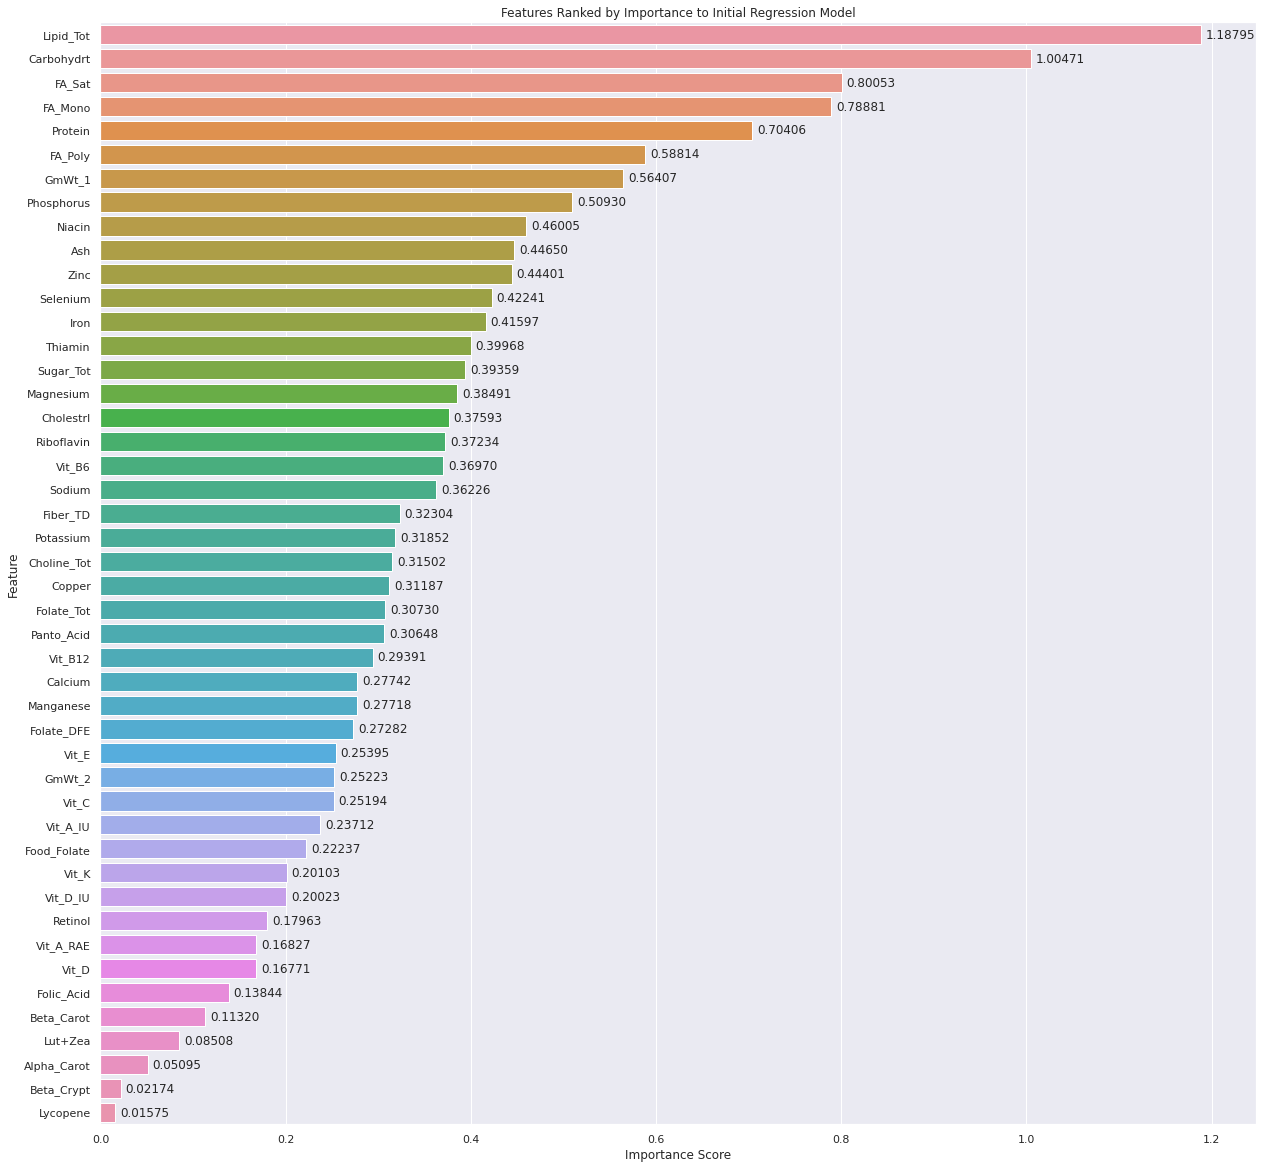

In [186]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

labels = [col for col in df_chosen_x]
importance = list(model.feature_importances_)

y_train = np.ravel(y_train)

fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)

df_importance = pd.DataFrame({'labels': labels, 'importance': fs.scores_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=False)

ax=sns.barplot(x='importance', y='labels', data=df_importance_sorted, orient='h')
ax.bar_label(container=ax.containers[0], fmt='%1.5f', label_type='edge', padding=5)
sns.set(rc={'figure.figsize':(20.7, 20.27)})
plt.title('Features Ranked by Importance to Initial Regression Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Feature Engineering

In [187]:
split_desc = df['Shrt_Desc'].str.split(',')

category = []
for split in split_desc:
    category.append(split[0])

In [188]:
df_eng = df

In [189]:
df_eng['Desc_Cat'] = category
df_eng['Desc_Cat'] = df_eng['Desc_Cat'].astype("category")

In [190]:
split_water = df_eng['Water'].str.split(' ')

water_g = []
for split in split_water:
    water_g.append(split[0])

water_g[1941]
df_eng['Water_Flt'] = water_g

df_eng = df_eng[df_eng['NDB_No']!=8370]

df_eng['Water_Flt'] = df_eng['Water_Flt'].astype('float')

# Truly Dealing with Null Data

In [191]:
df_eng = df_eng.drop(labels=['NDB_No', 'Shrt_Desc', 'Water', 'GmWt_Desc1', 'GmWt_1', 'GmWt_Desc2', 'GmWt_2'], axis=1)

In [192]:
df_eng_null = df_eng.isnull().sum()
high_null_list = df_eng_null[df_eng.isnull().sum()>2000].index

In [193]:
col = []
zeros = []

for column in high_null_list:
    try:
        zeros_count = df_eng[column].value_counts().loc[0.0]
        zeros.append(zeros_count)
        col.append(column)
    except:
        pass

df_zeros_high = pd.DataFrame({'zero_count':zeros}, index=col)

In [194]:
high_zeros_df = df_zeros_high[df_zeros_high['zero_count']>1000].index

In [195]:
for col in high_zeros_df:
    df_eng[col] = df_eng[col].fillna(0)

In [196]:
df_null_fill = df_eng
df_null_fill = df_null_fill.drop(labels='Desc_Cat', axis=1)
df_null_update = df_null_fill.isnull().sum()
df_null_columns = df_null_update[df_null_update>0].index
df_null_fill = df_null_fill.dropna(axis=0)

In [197]:
df_null_columns

Index(['Ash', 'Fiber_TD', 'Sugar_Tot', 'Calcium', 'Iron', 'Magnesium',
       'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Copper', 'Manganese',
       'Selenium', 'Vit_C', 'Thiamin', 'Riboflavin', 'Niacin', 'Panto_Acid',
       'Vit_B6', 'Folate_Tot', 'Food_Folate', 'Folate_DFE', 'Choline_Tot',
       'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE', 'Retinol', 'Vit_E', 'FA_Sat',
       'FA_Mono', 'FA_Poly', 'Cholestrl'],
      dtype='object')

In [206]:
df_prep = df_eng

for col in df_null_columns:
    df_null_fill[col] = df_null_fill[col].replace('None', pd.NA)
    df_x = df_null_fill.drop(labels=col, axis=1)
    df_y = df_null_fill[col]
    [X, y] = prepareData(df_x, df_y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model_na = xgb.XGBRegressor()
    model_na.fit(X_train, y_train)

    indices = df_eng[df_eng[col].isnull()].index
    df_predict = df_eng[df_eng[col].isnull()]
    X_predict = df_predict.drop(labels=[col, 'Desc_Cat'], axis=1).fillna(0).values
    predicted = model_na.predict(X_predict)
    for x, y in zip(indices, predicted):
        if (y > 0) and (y < df_eng[col].max()):
            df_prep.loc[x, col] = round(y, 2)
        elif y < 0:
            df_prep.loc[x, col] = 0
        else:
            df_prep.loc[x, col] = round(df_eng[col].max(), 2)

In [209]:
for col in df_prep:
    try:
        df_prep[col] = df_prep[col].round(2)
    except:
        pass

In [361]:
df_prep_x = df_prep.drop(labels='Energ_Kcal', axis=1)
df_prep_y = df_prep['Energ_Kcal']

# Tuning Hyperparameters

### Finding Optimal Early Stopping Rounds

In [363]:
# https://practicaldatascience.co.uk/machine-learning/how-to-avoid-model-overfitting-with-early-stopping-rounds

X_train, X_test, y_train, y_test = train_test_split(df_prep_x, df_prep_y, test_size=0.3, random_state=0)

In [365]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,
          y_train,
          eval_metric="rmse",
          eval_set=eval_set,
          verbose=False)
results = model.evals_result()

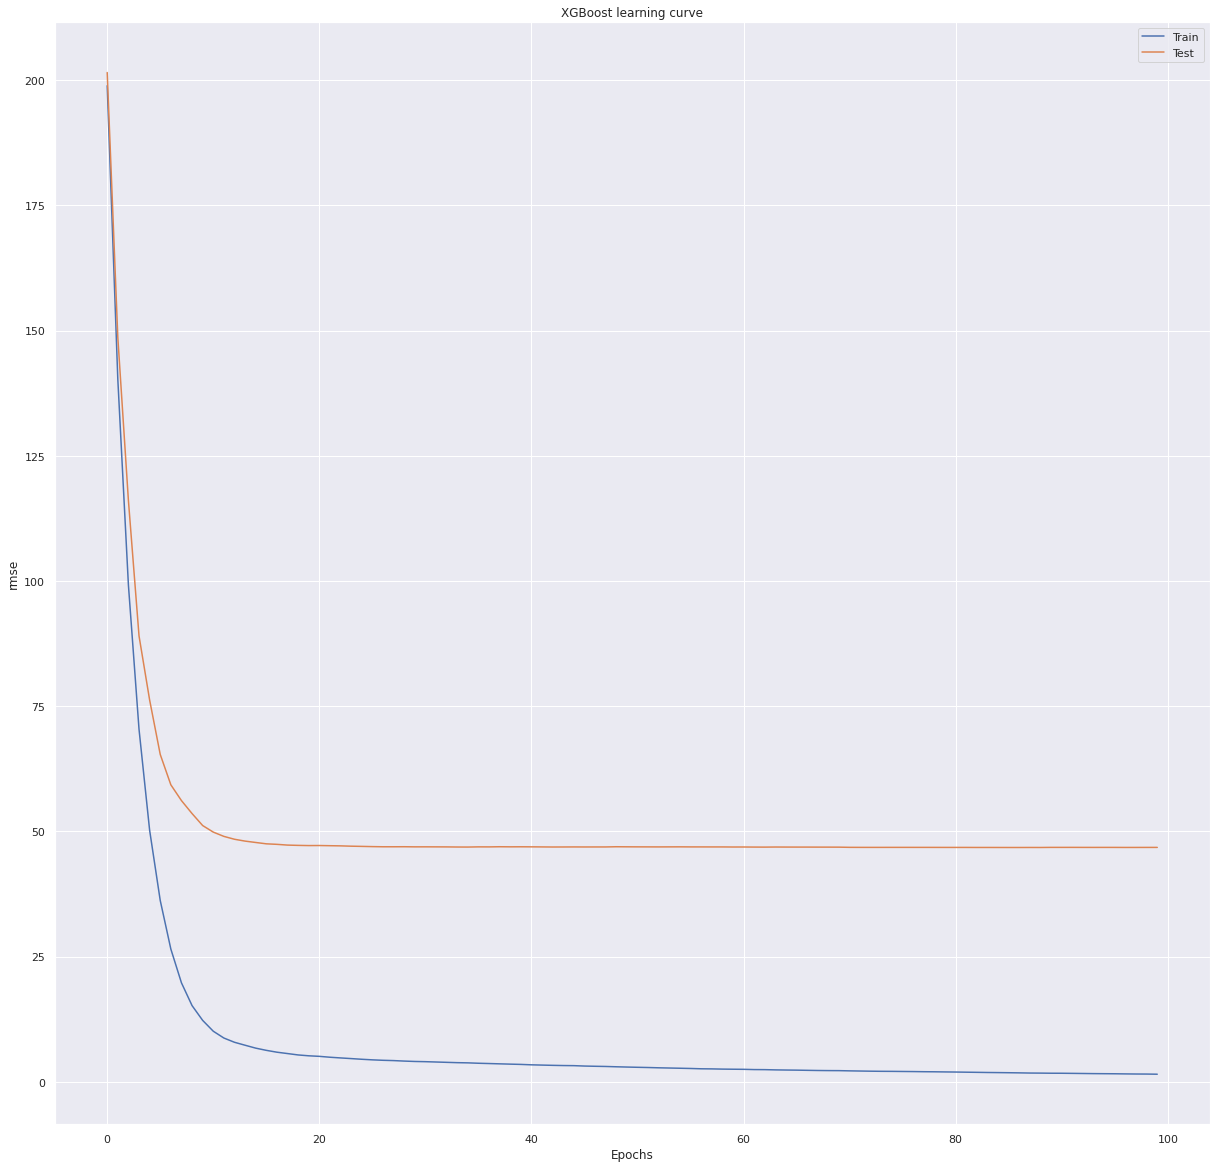

In [368]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('rmse')
plt.title('XGBoost learning curve')
plt.show()

In [297]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

class tuneHyperParams(object):

    def __init__(self, model, x_data, y_data, test_size, scoring):
        self.model = model
        self.x_data = x_data
        self.y_data = y_data
        self.test_size = test_size
        self.scoring = scoring

    def getTestTrainData(self):
        X_train, X_test, y_train, y_test = train_test_split(self.x_data, self.y_data, test_size=self.test_size, random_state=0)
        return X_train, X_test, y_train, y_test

    def obtainBestKFolds(self, X_train, y_train, val_range):
        df_scores = pd.DataFrame(columns=['kfolds', self.scoring])
        for k in val_range:
            cv = StratifiedKFold(n_splits=k, random_state=0, shuffle=True)
            score = cross_validate(self.model, X_train, y_train, scoring=self.scoring, cv=cv, n_jobs=-1)
            score_mean = score['test_score'].mean()
            df_scores = pd.concat([df_scores, pd.DataFrame.from_records([{'kfolds':int(k), '{}'.format(self.scoring):score_mean}])], ignore_index=True)
        best_value_list = list(df_scores[self.scoring].values)
        k_values_list = list(df_scores['kfolds'].values)
        best_value = max(best_value_list)
        best_index = best_value_list.index(best_value)
        kfolds_best = k_values_list[best_index]
        return kfolds_best

    def tuneModel(self, X, y, kfolds, params_grid):
        cv = StratifiedKFold(n_splits=kfolds, random_state=0, shuffle=True)
        gsearch = GridSearchCV(estimator=self.model,
                                param_grid = params_grid, scoring=self.scoring,n_jobs=-1, cv=cv)
        grid_result = gsearch.fit(X, y)
        return grid_result

In [298]:
def tuneXGBoost(set_params, params_grid, first_time=True, X_train=None, y_train=None, best_k=None):
    model = xgb.XGBRegressor(params=set_params, enable_categorical=True, tree_method='hist')

    XGB = tuneHyperParams(model, df_prep_x, df_prep_y, 0.3, 'r2')

    if first_time is True:
        [X_train, X_test, y_train, y_test] = XGB.getTestTrainData()
        best_k = XGB.obtainBestKFolds(X_train, y_train, range(2, 21))
        grid_result = XGB.tuneModel(X_train, y_train, best_k, params_grid)
        return grid_result, X_train, X_test, y_train, y_test, best_k

    elif first_time is False:
        grid_result = XGB.tuneModel(X_train, y_train, best_k, params_grid)
        return grid_result

    else:
        grid_result = None
        return grid_result

In [299]:
import warnings
warnings.filterwarnings("ignore")

In [301]:
params_test1 = {
    'max_depth': range(15, 22, 1),
    'min_child_weight': range(1,6,1)
}

params_set1 = {
    'learning_rate': 0.1,
    'max_depth': 20
}

[grid_result, X_train, X_test, y_train, y_test, best_k] = tuneXGBoost(params_set1, params_test1)

[20:49:06] WARNING: ../src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [304]:
print(grid_result.best_params_)
print(grid_result.best_score_)
print(best_k)

{'max_depth': 16, 'min_child_weight': 3}
0.9871647672793975
4


In [312]:
params_test2 = {
    'gamma': [i/10 for i in range(4, 11, 1)]
}
params_set2 = {
    'learning_rate': 0.1,
    'max_depth': 16,
    'min_child_weight': 3,
    'early_stopping_rounds':10
}

grid_result2 = tuneXGBoost(params_set2, params_test2, first_time=False, X_train=X_train, y_train=y_train, best_k=best_k)

[21:00:11] WARNING: ../src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [313]:
print(grid_result2.best_params_)
print(grid_result2.best_score_)

{'gamma': 0.6}
0.8865321287793619
